In [1]:
import gc
import os

import keras
from keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import signal
from sklearn import metrics
import tensorflow as tf

In [2]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Problem 

The problem statement is described in detail [here](https://archive.ics.uci.edu/ml/datasets/PPG-DaLiA).  Fifteen subjects were asked to wear a chest-mounted device and a wrist-mounted device and perform a range of activities: 
* **Sitting**: Sitting still while reading.
* **Ascending and descending stairs**: Climbing six floors up and going down again. 
* **Playing table soccer**
* **Cycling**: Performed outdoors about 2km length with varying road conditions (gravel, paved).
* **Driving a car**: Subjects followed a defined route which took about 15 minutes to complete. The route included driving on different streets in a small city as well
as driving on country roads.
* **Lunch break**: The activity included queuing and fetching food, eating, and talking at the table.
* **Walking**: Walking back from the canteen to the office, with some detour.
* **Working**: For each subject, work mainly consisted of working on a computer.

ECG signals were measured using the chest-mounted device at a 700Hz sampling frequency.  PPG and wrist acceleration signals were measured using the wrist-mounted device at 64Hz sampling frequency.  The ECG signal was segmented into frames of 8 seconds and 2 second shifts (75% overlap between frames).  The segmented ECG signal was used to calculate heart rate ground truth, provided as a 'label' array. 

The goal of this project was to build a machine learning model to predict heart rate from the PPG device, synchronized to the ECG-derived 'label' data for comparison to the ground truth.

The authors of this dataset [report](https://www.mdpi.com/1424-8220/19/14/3079/htm) an MAE (mean absolute error) of 7.65 bpm using STFT and CNN based approaches.    

# Solution

The solution involved visually analyzing the PPG signals in all three domains: time, time-frequency, and wavelet domains.  The features and periodicity of the features in all three domains was visually compared to the reference ECG signals, after time-synchronization.  The ECG signal was resampled (from 700 Hz to 64 Hz) for comparison to the PPG signal. The PPG signal was then segmented into 8 second frames with a 2 second shift (75% overlap between frames) to align with the 'label' data.   
    
The wavelet domain representation of the PPG signal showed the most consistent and prominent features that aligned with the ECG beats and that were most immune to motion noise.  Thus, the time domain and wavelet domain representations were chosen for building the machine learning models. Data from the subjects 1-7 was used for training, data from subjects 8-11 was used for validation, and data from subjects 12-15 was used for testing/inference.   

Two models were compared: 
* Model 1: time domain and wavelet domain combined (CONV1D and LSTM were used to process the time-domain signal and CONV2D and MaxPool2D were used to process the wavelet domain image)
* Model 2: wavelet domain alone (using just the CONV2D and MaxPool2D branch)

In both cases, MAE (in bpm) was computed using the heart rate obtained with and without post-processing.  For post-processing, the Savitzky-Golay smoothing filter was used to reduce variability of detected heart rate between frames. 

The results (test MAE) obtained were as follows: 

| Model Architecture | Signal Postprocessing | MAE (bpm) |
|--------------------|-----------------------|-----------|
| Model 1 (time and wavelet) | No            | 15.8 |
| Model 1 (time and wavelet) | Yes           | 14.62 |
| Model 2 (wavelet alone)    | No            | 10.13 |
| Model 2 (wavelet alone)    | Yes           | 9.28  |


## Exploratory Analysis of Data

In [30]:
with open('PPG_FieldStudy/S2/S2.pkl', 'rb') as file:
    data_dict = pickle.load(file, encoding='latin1')

In [31]:
print(data_dict.keys())
print(data_dict['signal'].keys())
print(data_dict['signal']['chest'].keys())
print(data_dict['signal']['wrist'].keys())
print(data_dict['signal']['wrist']['BVP'].shape)
print(data_dict['label'].shape)

dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])
dict_keys(['chest', 'wrist'])
dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
(525120, 1)
(4099,)


In [32]:
labels = data_dict['label']
print(labels)

[70.9229657  71.29105528 68.69383264 ... 95.13817648 96.7405001
 96.84438537]


In [33]:
chest_signals = data_dict['signal']['chest']
wrist_signals = data_dict['signal']['wrist']

chest_acc = chest_signals['ACC']
ecg = chest_signals['ECG']
wrist_ppg = wrist_signals['BVP']
wrist_acc = wrist_signals['ACC']

ecg_downsamp = signal.resample_poly(ecg, up=64, down=700)

In [34]:
print(len(wrist_ppg))

525120


In [35]:
print(len(ecg_downsamp))

525120


In [9]:
b, a = signal.butter(4, 1.0, 'lowpass', analog=True)
wrist_ppg_filt_1 = signal.filtfilt(b, a, wrist_ppg.squeeze(), padtype=None)
wrist_ppg_filt_2 = signal.savgol_filter(wrist_ppg_filt_1, window_length=101, polyorder=1)
wrist_ppg_filt = wrist_ppg_filt_1 - wrist_ppg_filt_2

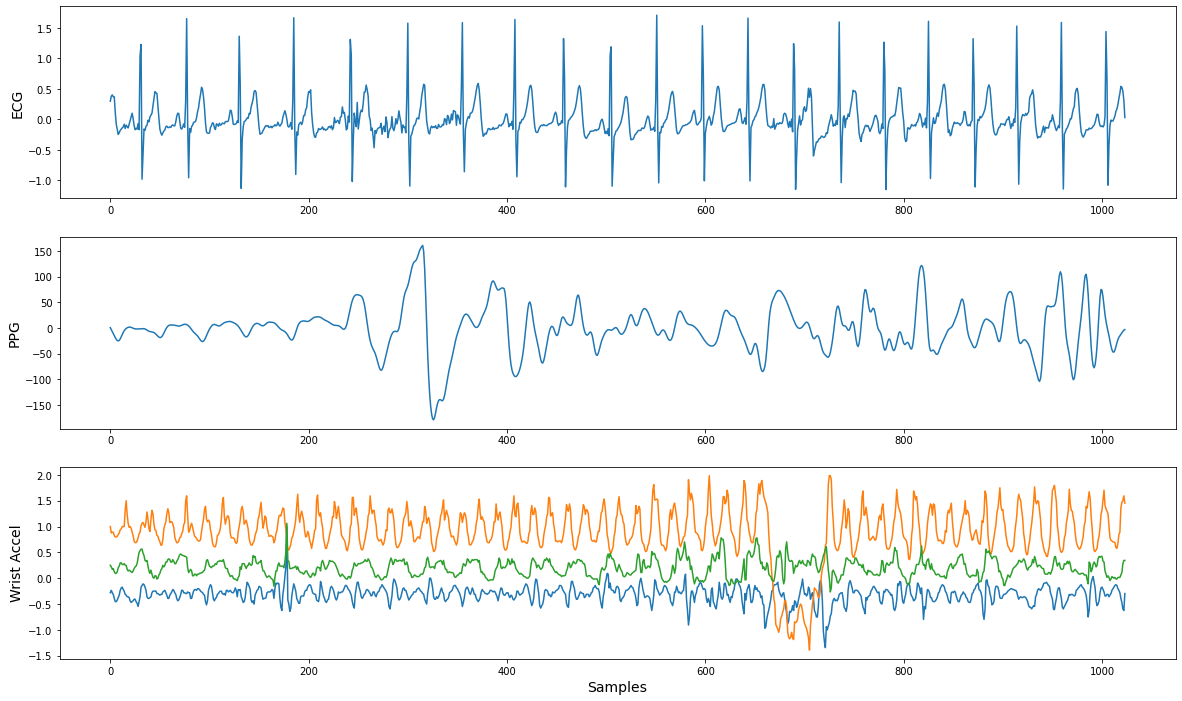

In [36]:
START = 250*8*64
END = 252*8*64

plt.figure(figsize=(20,12))

plt.subplot(3,1,1)
plt.plot(ecg_downsamp[START:END])
plt.ylabel('ECG', fontsize=14)

plt.subplot(3,1,2)
plt.plot(wrist_ppg[START:END])
plt.ylabel('PPG', fontsize=14)

plt.subplot(3,1,3)
_ = plt.plot(wrist_acc[START:END])
plt.xlabel('Samples', fontsize=14)
_ = plt.ylabel('Wrist Accel', fontsize=14)

## Comparison of Spectrogram (STFT) and Wavelet Spectra

The heart beat patterns show up more prominently in the wavelet spectra.

### Spectrogram

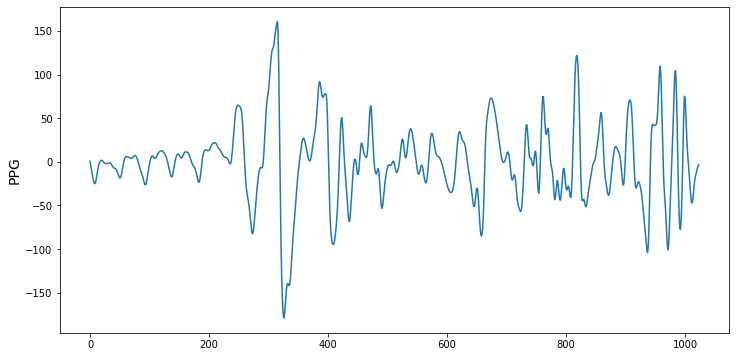

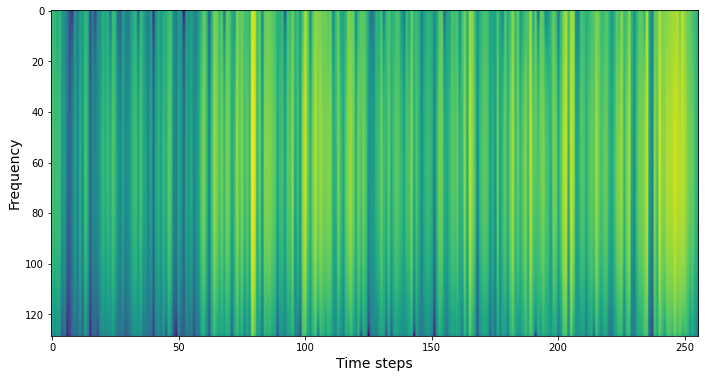

In [38]:
plt.figure(figsize=(12,6))
plt.plot(wrist_ppg[START:END])
plt.ylabel('PPG', fontsize=14)

plt.figure(figsize=(12,6))
f, t, sxx = signal.spectrogram(wrist_ppg[START:END].transpose(), fs=64, nperseg=4, nfft=256)
sxx[sxx==0] = 1e-14
log_sxx = np.log(sxx)
plt.imshow(log_sxx.squeeze())
plt.xlabel('Time steps', fontsize=14)
_ = plt.ylabel('Frequency', fontsize=14)

### Wavelet

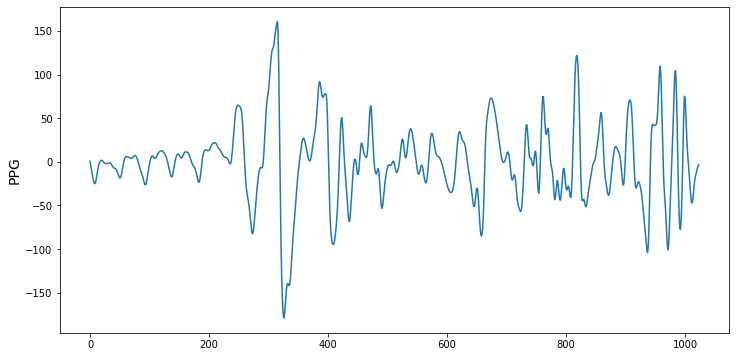

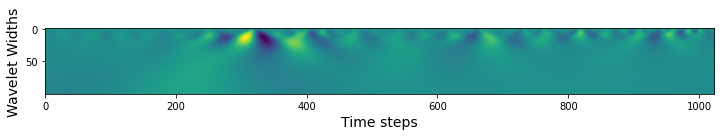

In [41]:
sig = wrist_ppg[START:END].squeeze()

plt.figure(figsize=(12,6))
plt.plot(sig)
plt.ylabel('PPG', fontsize=14)

widths = np.arange(1, 101)
sig_cwt = signal.cwt(sig, signal.ricker, widths) / 1000

fig = plt.figure(figsize=(12,6))
_ = plt.imshow(sig_cwt)
plt.xlabel('Time steps', fontsize=14)
_ = plt.ylabel('Wavelet Widths', fontsize=14)

## Preprocessing

In [2]:
WINDOW = 8 # seconds
SHIFT = 2 # seconds
FS = 64
WAVELET_SCALE = 1000

def segment_signal(sig, labels):
    frame_len = WINDOW * FS
    jump = SHIFT * FS
    sig_segmented = []
    
    widths = np.arange(1, 101)
    cwt_img = []
    
    no_frames = (len(sig) - frame_len) // (jump) + 1
    no_labels = len(labels)
    
    frame = 0
    
    while(frame * jump + frame_len) <= len(sig):
        sig_sub = sig[frame * jump : frame * jump + frame_len]
        sig_segmented.append(sig_sub / np.max(sig_sub))
        sig_cwt = signal.cwt(sig_sub, signal.ricker, widths) / WAVELET_SCALE
        cwt_img.append(sig_cwt)
        frame += 1
        
    truncated_sig_segmented = sig_segmented[:min(no_frames, no_labels)]
    truncated_labels = labels[:min(no_frames, no_labels)]
    
    return np.array(truncated_sig_segmented), np.array(cwt_img), truncated_labels

In [3]:
WINDOW = 8 # seconds
SHIFT = 2 # seconds
FS = 64
WAVELET_SCALE = 1000

def align_signal_and_labels(sig, labels):
    frame_len = WINDOW * FS
    jump = SHIFT * FS
    sig_segmented = []
    
    
    no_frames = (len(sig) - frame_len) // (jump) + 1
    no_labels = len(labels)
    
    frame = 0
    
    while(frame * jump + frame_len) <= len(sig):
        sig_sub = sig[frame * jump : frame * jump + frame_len]
        sig_segmented.append(sig_sub / np.max(sig_sub))
        frame += 1
        
    truncated_sig_segmented = sig_segmented[:min(no_frames, no_labels)]
    truncated_labels = labels[:min(no_frames, no_labels)]
    
    return np.array(truncated_sig_segmented), truncated_labels

In [42]:
sig_segmented, cwt_img, truncated_labels = segment_signal(wrist_ppg.squeeze(), labels)

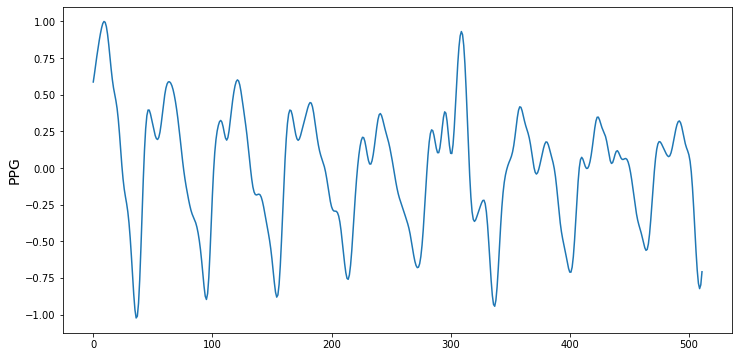

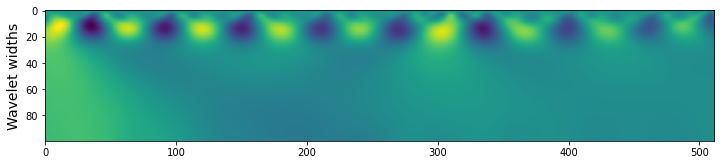

In [44]:
fig = plt.figure(figsize=(12,6))
plt.plot(sig_segmented[8, :].squeeze())
plt.ylabel('PPG', fontsize=14)

fig = plt.figure(figsize=(12,6))
_ = plt.imshow(cwt_img[8, :, :])
_ = plt.ylabel('Wavelet widths', fontsize=14)

In [4]:
dd = {'train': list(range(1, 8)),
      'val':   list(range(8, 12)),
      'test': list(range(12, 16)) }


def prepare_data(what='train'):
    final_sig_segmented = []
    final_labels = []
    
    frame_len = WINDOW * FS
    jump = SHIFT * FS

    for sub_id in dd[what]:
        with open(f'PPG_FieldStudy/S{sub_id}/S{sub_id}.pkl', 'rb') as file:
            data_dict = pickle.load(file, encoding='latin1')
            
        wrist_signals = data_dict['signal']['wrist']
        wrist_ppg = wrist_signals['BVP']
        
        truncated_sig_segmented, truncated_labels = align_signal_and_labels(wrist_ppg.squeeze(), data_dict['label'])
        
        final_sig_segmented.append(truncated_sig_segmented)
        
        final_labels.extend(list(truncated_labels))
        
    final_sig_segmented_np = np.vstack(final_sig_segmented)
    
    
    return np.array(final_sig_segmented_np), np.array(final_labels)
    

In [5]:
def scale_labels():
    _, final_labels = prepare_data("train")
    MEAN = np.mean(final_labels)
    STD = np.std(final_labels)
    
    return MEAN, STD

In [6]:
WAVELET_SCALE = 1000
widths = np.arange(1, 31)


class DataGenPreprocessOnTheFly(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16, shuffle=False):
        self.what = what
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.final_sig_segmented, self.final_labels = prepare_data(what=self.what)
       
        
    def __len__(self):    
        return int(np.ceil(self.final_sig_segmented.shape[0] / self.batch_size))
        
    def __getitem__(self, batch_num):
        
        MEAN, STD = scale_labels()
        
        sig_segmented, final_labels = self.final_sig_segmented, self.final_labels   
        y = []
        sig_len = self.sig_len
        batch_size = self.batch_size             
        cwt_img = []
        
        labels = final_labels[batch_num * batch_size : (batch_num + 1) * batch_size]
        
        labels = (labels - MEAN) / STD
        
        td_all = sig_segmented[batch_num * batch_size : (batch_num + 1) * batch_size, :]
        
        for sig in td_all:
            sig_cwt = signal.cwt(sig, signal.ricker, widths) / WAVELET_SCALE
            cwt_img.append(sig_cwt)
        
        wavelet_img_all = cwt_img

        td_all = np.expand_dims(td_all, -1)
        wavelet_img_all = np.expand_dims(wavelet_img_all, -1)

        y = labels
        
        return (np.array(td_all), np.array(wavelet_img_all)), np.array(y)
        
    def on_epoch_end(self):
        pass

In [7]:
train_gen = DataGenPreprocessOnTheFly(what='train', batch_size=16, shuffle=False)
val_gen = DataGenPreprocessOnTheFly(what='val', batch_size=16, shuffle=False)

In [34]:
print(train_gen[0][0][0].shape)
print(train_gen[0][0][1].shape)
print(train_gen[0][1].shape)

(16, 512, 1)
(16, 30, 512, 1)
(16,)


In [6]:
dd = {'train': list(range(1, 8)),
      'val':   list(range(8, 12)),
      'test': list(range(12, 16)) }

WINDOW = 8 # seconds
SHIFT = 2 # seconds
FS = 64
WAVELET_SCALE = 1000
widths = np.arange(1, 31)

MEAN, STD = scale_labels()

def preprocess(what='train'):
    if not os.path.exists(os.path.join('keya_preprocessed', what)):
        os.makedirs(os.path.join('keya_preprocessed', what))
    
    frame_len = WINDOW * FS
    jump = SHIFT * FS
       
    final_sig_segmented = []
    final_cwt = []
    final_labels = []
    
    frame_len = WINDOW * FS
    jump = SHIFT * FS

    for sub_id in dd[what]:
        with open(f'PPG_FieldStudy/S{sub_id}/S{sub_id}.pkl', 'rb') as file:
            data_dict = pickle.load(file, encoding='latin1')
            print('File loaded')
            
        wrist_signals = data_dict['signal']['wrist']
        wrist_ppg = wrist_signals['BVP']
        
        sig = wrist_ppg.squeeze()
        
        labels = data_dict['label']
        labels = (labels - MEAN) / STD
    
        no_frames = (len(sig) - frame_len) // (jump) + 1
        no_labels = len(labels)

        frame = 0
        sig_segmented = []
        cwt_img = []
        
        print(f'About to calculate frames for {sub_id}')
        #print(len(sig), no_frames, no_labels)
        while(frame * jump + frame_len) <= len(sig):
            sig_sub = sig[frame * jump : frame * jump + frame_len]
            sig_cwt = signal.cwt(sig_sub, signal.ricker, widths) / WAVELET_SCALE
            cwt_img.append(sig_cwt)
            sig_segmented.append(sig_sub / np.max(sig_sub))
            frame += 1
        
        truncated_sig_segmented = sig_segmented[:min(no_frames, no_labels)]
        truncated_labels = labels[:min(no_frames, no_labels)]
        
        final_sig_segmented.append(truncated_sig_segmented)
        final_cwt.append(cwt_img)
        final_labels.extend(list(truncated_labels))
        
        gc.collect()
        
    final_sig_segmented_np = np.vstack(final_sig_segmented)
    final_cwt_np = np.vstack(final_cwt)

    dd_to_save = {'TD': final_sig_segmented_np, 
          'WD': final_cwt_np, 
          'labels': np.array(final_labels)}
    
    np.save(os.path.join('keya_preprocessed', what, f'{what}.npy'), dd_to_save)

In [24]:
preprocess("train")

File loaded
About to calculate frames for 1
File loaded
About to calculate frames for 2
File loaded
About to calculate frames for 3
File loaded
About to calculate frames for 4
File loaded
About to calculate frames for 5
File loaded
About to calculate frames for 6
File loaded
About to calculate frames for 7


In [25]:
preprocess("val")

File loaded
About to calculate frames for 8
File loaded
About to calculate frames for 9
File loaded
About to calculate frames for 10
File loaded
About to calculate frames for 11


## Time Domain and Wavelet Domain 

In [21]:
class DataGen(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16, shuffle=False):
        self.what = what
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dd_to_save = np.load(os.path.join('keya_preprocessed', self.what, f'{self.what}.npy'), allow_pickle=True)
        dd_to_save = self.dd_to_save.item()
        self.final_sig_segmented_np = dd_to_save['TD']
        self.final_cwt_np = dd_to_save['WD']
        self.final_labels = dd_to_save['labels']
        
    def __len__(self):    
        return int(np.ceil(self.final_sig_segmented_np.shape[0] / self.batch_size))
        
    def __getitem__(self, batch_num):
        
        final_sig_segmented, final_cwt, final_labels = self.final_sig_segmented_np, self.final_cwt_np, self.final_labels   
        
        batch_size = self.batch_size             
        
        labels = final_labels[batch_num * batch_size : (batch_num + 1) * batch_size]
        
        td_all = final_sig_segmented[batch_num * batch_size : (batch_num + 1) * batch_size, :]
        
        wavelet_img_all = final_cwt[batch_num * batch_size : (batch_num + 1) * batch_size, :, :]

        td_all = np.expand_dims(td_all, -1)
        wavelet_img_all = np.expand_dims(wavelet_img_all, -1)

        y = labels
        
        return (np.array(td_all), np.array(wavelet_img_all)), np.array(y)
        
    def on_epoch_end(self):
        pass

In [23]:
train_gen = DataGen(what='train', batch_size=16, shuffle=False)
val_gen = DataGen(what='val', batch_size=16, shuffle=False)

In [24]:
print(train_gen[0][0][0].shape)
print(train_gen[0][0][1].shape)
print(train_gen[0][1].shape)

(16, 512, 1)
(16, 30, 512, 1)
(16,)


## Building The Model 

In [25]:
def build_model():
    td_inp = keras.Input(shape=(512, 1), name='td_inp')
    wavelet_inp = keras.Input(shape=(30, 512, 1), name='wavelet_inp')
    
    # Time domain
    x = layers.Conv1D(64, 7, activation='relu')(td_inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128))(x)
    time_output = layers.Dropout(0.2)(x)
    
    
    # Wavelet Domain
    x = layers.Conv2D(32, (3, 3), activation='relu')(wavelet_inp)
    x = layers.MaxPool2D((1, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
    wavelet_output = layers.Dropout(0.2)(x)
    
    concatenated = layers.concatenate([time_output, wavelet_output], axis=-1)
    x = layers.Dense(128, activation='relu')(concatenated)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    out = keras.layers.Dense(1)(x)
    
    
    model = keras.Model(inputs=[td_inp, wavelet_inp], outputs=out)
    model.compile(
        loss='mae',
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['mse'],
    )
    
    return model

In [72]:
model = build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wavelet_inp (InputLayer)        [(None, 30, 512, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 510, 32)  320         wavelet_inp[0][0]                
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 28, 255, 32)  0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 26, 253, 64)  18496       max_pooling2d_8[0][0]            
____________________________________________________________________________________________

In [73]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_td_wd.h5', save_best_only=True, monitor='loss'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list,
                    validation_data=val_gen, 
                    epochs=10,
                    verbose=1,
                    )

gc.collect()

Epoch 1/10
1849/1849 [==============================] - 135s 72ms/step - loss: 0.6557 - mse: 0.7852 - val_loss: 0.4070 - val_mse: 0.3346
Epoch 2/10
1849/1849 [==============================] - 131s 71ms/step - loss: 0.3782 - mse: 0.3263 - val_loss: 0.3799 - val_mse: 0.3236
Epoch 3/10
1849/1849 [==============================] - 132s 72ms/step - loss: 0.3373 - mse: 0.2715 - val_loss: 0.3543 - val_mse: 0.2817
Epoch 4/10
1849/1849 [==============================] - 132s 71ms/step - loss: 0.3273 - mse: 0.2686 - val_loss: 0.3393 - val_mse: 0.2628
Epoch 5/10
1849/1849 [==============================] - 132s 71ms/step - loss: 0.2849 - mse: 0.2085 - val_loss: 0.3379 - val_mse: 0.2658
Epoch 6/10
1849/1849 [==============================] - 132s 71ms/step - loss: 0.2708 - mse: 0.1909 - val_loss: 0.3505 - val_mse: 0.2938
Epoch 7/10
1849/1849 [==============================] - 132s 71ms/step - loss: 0.2506 - mse: 0.1898 - val_loss: 0.2950 - val_mse: 0.2270
Epoch 8/10
1849/1849 [===================

59877

Min Validation MAE:  0.29498130083084106


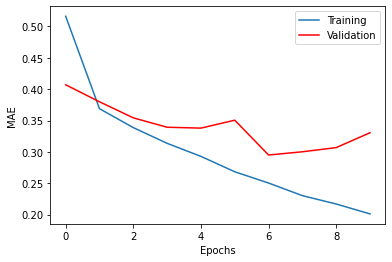

In [74]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

print("Min Validation MAE: ", np.min(history.history['val_loss']))

## Inference

In [8]:
preprocess('test')

File loaded
About to calculate frames for 12
File loaded
About to calculate frames for 13
File loaded
About to calculate frames for 14
File loaded
About to calculate frames for 15


In [22]:
test_gen = DataGen('test', batch_size=16, shuffle=False)
no_of_test_files = len(test_gen)
model = keras.models.load_model('keya_model_td_wd.h5')

In [23]:
MEAN, STD = scale_labels()

def inverse_scale_labels(y_pred_scaled):
    y_pred = [(x * STD + MEAN) for x in y_pred_scaled]
    return y_pred

In [24]:
BATCH_SIZE = 16

y_final = []
y_true = []
for batch in range(int(np.ceil(no_of_test_files / BATCH_SIZE))):
    y_final_scaled = model.predict(test_gen[batch][0])
    y_final.extend(inverse_scale_labels(y_final_scaled))
    y_true.extend(inverse_scale_labels(test_gen[batch][1]))

In [30]:
MAE = metrics.mean_absolute_error(y_true, y_final)
print("Mean Absolute Error = ", MAE)

Mean Absolute Error =  15.799320041876872


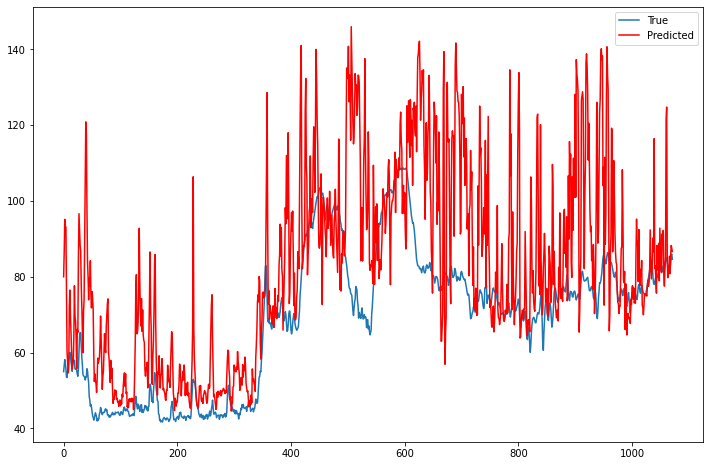

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y_final, 'r', label='Predicted')
_ = plt.legend()

### Filtering the predicted heart rate

In [25]:
y_final_filt = signal.savgol_filter(np.array(y_final).squeeze(), window_length=11, polyorder=1)

In [26]:
MAE = metrics.mean_absolute_error(y_true, y_final_filt)
print("Mean Absolute Error = ", MAE)

Mean Absolute Error =  14.624991598320143


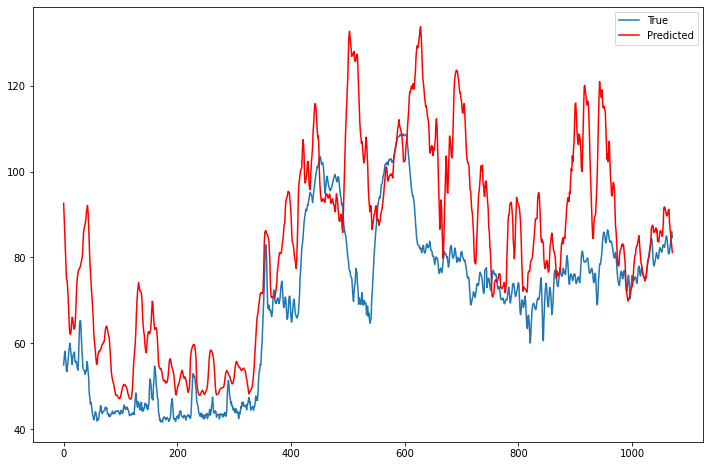

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y_final_filt, 'r', label='Predicted')
_ = plt.legend()

## Wavelet Domain Alone

In [8]:
class DataGen_WD(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16, shuffle=False):
        self.what = what
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dd_to_save = np.load(os.path.join('keya_preprocessed', self.what, f'{self.what}.npy'), allow_pickle=True)
        dd_to_save = self.dd_to_save.item()
        self.final_sig_segmented_np = dd_to_save['TD']
        self.final_cwt_np = dd_to_save['WD']
        self.final_labels = dd_to_save['labels']
        
    def __len__(self):    
        return int(np.ceil(self.final_sig_segmented_np.shape[0] / self.batch_size))
        
    def __getitem__(self, batch_num):
        
        final_sig_segmented, final_cwt, final_labels = self.final_sig_segmented_np, self.final_cwt_np, self.final_labels   
        
        batch_size = self.batch_size             
        
        labels = final_labels[batch_num * batch_size : (batch_num + 1) * batch_size]
        
        td_all = final_sig_segmented[batch_num * batch_size : (batch_num + 1) * batch_size, :]
        
        wavelet_img_all = final_cwt[batch_num * batch_size : (batch_num + 1) * batch_size, :, :]

        td_all = np.expand_dims(td_all, -1)
        wavelet_img_all = np.expand_dims(wavelet_img_all, -1)

        y = labels
        
        return np.array(wavelet_img_all), np.array(y)
        
    def on_epoch_end(self):
        pass

In [8]:
train_gen = DataGen_WD(what='train', batch_size=16, shuffle=False)
val_gen = DataGen_WD(what='val', batch_size=16, shuffle=False)

In [9]:
def build_model_wd():
    
    wavelet_inp = keras.Input(shape=(30, 512, 1), name='wavelet_inp')
    
    # Wavelet Domain
    x = layers.Conv2D(32, (3, 3), activation='relu')(wavelet_inp)
    x = layers.MaxPool2D((1, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Flatten()(x)
    wavelet_output = layers.Dropout(0.2)(x)
    
    x = layers.Dense(128, activation='relu')(wavelet_output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    out = keras.layers.Dense(1)(x)
    
    
    model = keras.Model(inputs=wavelet_inp, outputs=out)
    model.compile(
        loss='mae',
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['mse'],
    )
    
    return model

In [10]:
model = build_model_wd()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wavelet_inp (InputLayer)     [(None, 30, 512, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 510, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 255, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 253, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 126, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 124, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 62, 128)        0     

In [11]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_wd.h5', save_best_only=True, monitor='loss'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list,
                    validation_data=val_gen, 
                    epochs=10,
                    verbose=1,
                    )

gc.collect()

Epoch 1/10
1849/1849 [==============================] - 21s 10ms/step - loss: 0.6501 - mse: 0.7862 - val_loss: 0.4081 - val_mse: 0.3640
Epoch 2/10
1849/1849 [==============================] - 16s 9ms/step - loss: 0.3794 - mse: 0.3137 - val_loss: 0.3896 - val_mse: 0.3247
Epoch 3/10
1849/1849 [==============================] - 16s 9ms/step - loss: 0.3386 - mse: 0.2839 - val_loss: 0.3454 - val_mse: 0.2764
Epoch 4/10
1849/1849 [==============================] - 16s 9ms/step - loss: 0.3209 - mse: 0.2606 - val_loss: 0.3527 - val_mse: 0.2944
Epoch 5/10
1849/1849 [==============================] - 16s 9ms/step - loss: 0.2910 - mse: 0.2205 - val_loss: 0.3363 - val_mse: 0.2755
Epoch 6/10
1849/1849 [==============================] - 16s 9ms/step - loss: 0.2783 - mse: 0.2033 - val_loss: 0.3608 - val_mse: 0.3319
Epoch 7/10
1849/1849 [==============================] - 16s 9ms/step - loss: 0.2508 - mse: 0.1693 - val_loss: 0.3580 - val_mse: 0.2922
Epoch 8/10
1849/1849 [==============================] 

62

Min Validation MAE:  0.3167679011821747


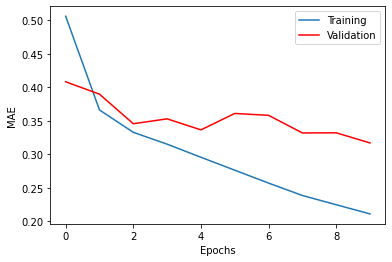

In [12]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

print("Min Validation MAE: ", np.min(history.history['val_loss']))

## Inference

In [9]:
test_gen = DataGen_WD('test', batch_size=16, shuffle=False)
no_of_test_files = len(test_gen)
model = keras.models.load_model('keya_model_wd.h5')

In [10]:
MEAN, STD = scale_labels()

def inverse_scale_labels(y_pred_scaled):
    y_pred = [(x * STD + MEAN) for x in y_pred_scaled]
    return y_pred

In [11]:
BATCH_SIZE = 16

y_final = []
y_true = []
for batch in range(int(np.ceil(no_of_test_files / BATCH_SIZE))):
    y_final_scaled = model.predict(test_gen[batch][0])
    y_final.extend(inverse_scale_labels(y_final_scaled))
    y_true.extend(inverse_scale_labels(test_gen[batch][1]))

In [16]:
MAE = metrics.mean_absolute_error(y_true, y_final)
print("Mean Absolute Error = ", MAE)

Mean Absolute Error =  10.127556740809204


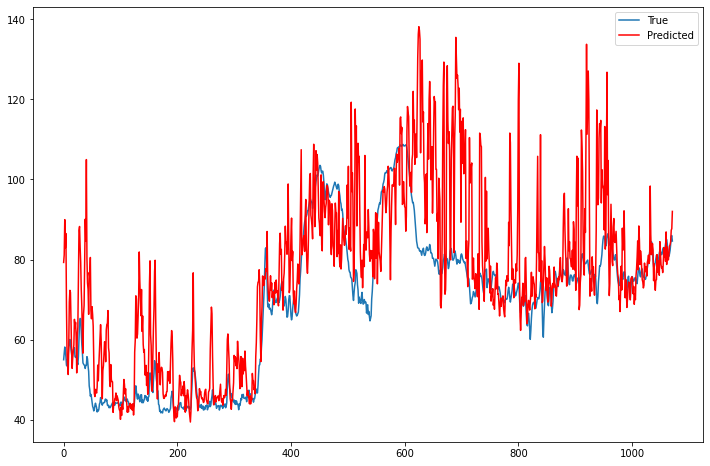

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y_final, 'r', label='Predicted')
_ = plt.legend()

### Filtering the predicted heart rate

In [13]:
y_final_filt = signal.savgol_filter(np.array(y_final).squeeze(), window_length=11, polyorder=1)

In [14]:
MAE = metrics.mean_absolute_error(y_true, y_final_filt)
print("Mean Absolute Error = ", MAE)

Mean Absolute Error =  9.275837114358913


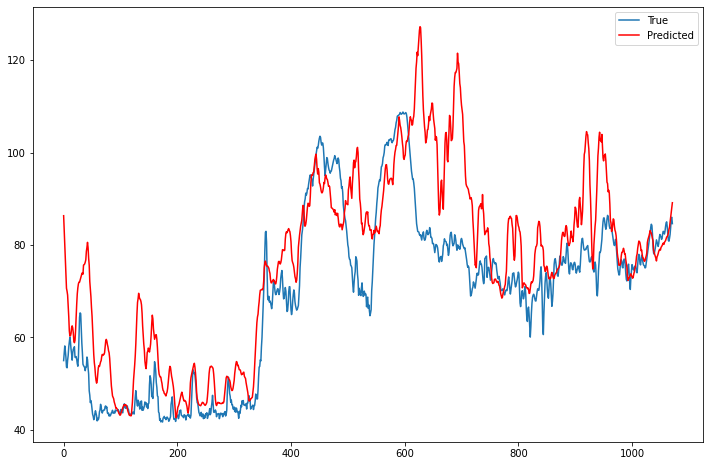

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y_final_filt, 'r', label='Predicted')
_ = plt.legend()